# Overview

This notebook aims to experiment with giving an agent access to two different databases (one sourced from my my personal website, one sourced from my published work, i.e. extracted from pdfs).

*Currently incomplete.*

In [3]:
#pip install -U langgraph langsmith
#!pip install -U "langchain[openai]"


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 12.1 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.65
    Uninstalling langchain-core-0.3.65:
      Successfully uninstalled langchain-core-0.3.65
  Attempting uninstall: langchain━━━━━━━━━━━━━━━ 0/2 [langchain-core]
    Found existing installation: langchain 0.3.250/2 [langchain-core]
    Uninstalling langchain-0.3.25:━━━━━━━━━━ 0/2 [langchain-core]
      Successfully uninstalled langchain-0.3.25m 0/2 [langchain-core]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [langchain]/2 [langchain]


In [ ]:

import os
import glob
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter, RecursiveCharacterTextSplitter
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pdf_folders = ["/home/georg/tools/webbing/morelight-md-version/files/papers",
                "/home/georg/academia/Produziertes/papers"
]
files = [f for folder in pdf_folders for f in os.listdir(folder) if os.path.isfile(f) and f.endswith('.pdf')]
files

['HSS2016_UnagreementItalian_RSS_fixed.pdf',
 'HoehnSilvestriSquillaci2016.pdf',
 'Hoehn2011_wroclaw_basqueko.pdf',
 'Hoehn2013_langborders_FoI2013_nomov.pdf',
 'languagePower_draft.pdf',
 'basque_locative_recos.pdf',
 'Hoehn2009_rusger_participles_handout.pdf',
 'Hoehn2014_console21.pdf',
 'handout_unagreement_ISTAL.pdf',
 'Hoehn2012_MRes_greekunagreement.pdf',
 'Hoehn2012_The-Licensing-of-Adnominal-PPs-The-Case-of-Basque-ko.pdf',
 'Hoehn2017_Nonpossessive person in the nominal domain.pdf',
 'Hoehn2015_Demonstratives and personal pronouns.pdf',
 'Hoehn2014_Semantics of unagreement.pdf',
 'hoehn_unagreement_NLLT.pdf',
 'Hoehn2018_draft_ElicitNomPers.pdf',
 'MGDLT10_Greko and Greek PPs_poster.pdf',
 '07_Bachelor',
 '15_Demonstratives+PersonalPron_CWPL',
 '15_ItalianUnagreement',
 'Hoehn2012_The-Licensing-of-Adnominal-PPs-The-Case-of-Basque-ko.pdf',
 'HoehnSilvestriSquillaci2017_Greek and Romance unagreement in Calabria.pdf',
 'Hoehn2020_The third person gap in adnominal pronoun construc

In [ ]:
# identify all pdfs in folder
pdf_folders = ["/home/georg/tools/webbing/morelight-md-version/files/papers",
                "/home/georg/academia/Produziertes/papers"
]
files = [f for folder in pdf_folders for f in os.listdir(folder) if os.path.isfile(f) and f.endswith('.pdf')]


# function for loading, splitting and chunking pdfs

def load_pdf(path,chunk_size=1000,chunk_overlap=200):
    loader = PyPDFLoader(path)
    pages = loader.load_and_split()
    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap
    )   
    chunks = text_splitter.split_documents(pages)

In [3]:
from langchain_huggingface import HuggingFaceEmbeddings
# from langchain.embeddings.base import Embeddings

# from sentence_transformers import SentenceTransformer


# from typing import List

# class CustomEmbeddings(Embeddings):
#     def __init__(self, model_name: str):
#         self.model = SentenceTransformer(model_name)

#     def embed_documents(self, documents: List[str]) -> List[List[float]]:
#         return [self.model.encode(d).tolist() for d in documents]

#     def embed_query(self, query: str) -> List[float]:
#         return self.model.encode([query])[0].tolist()
    
    
#embedder = HuggingFaceEmbeddings(model_name="Snowflake/snowflake-arctic-embed-m-v2.0")
# embedder="Snowflake/snowflake-arctic-embed-m-v2.0"
# embeddingsSN = SentenceTransformer(embedder)

import torch
from transformers import AutoModel, AutoTokenizer

model_name = 'Snowflake/snowflake-arctic-embed-m-v2.0'
tokenizer = AutoTokenizer.from_pretrained(model_name)
embedder = AutoModel.from_pretrained(model_name, add_pooling_layer=False, trust_remote_code=True)

Override attn_implementation='sdpa' to 'eager' as use_memory_efficient_attention='true'


In [8]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [9]:
import os
from langchain.chat_models import init_chat_model

import tiktoken
from IPython.display import Markdown, display
from  dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')
from langchain.tools.tavily_search import TavilySearchResults

load_dotenv()

llm = init_chat_model("openai:gpt-40-mini")

In [10]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [11]:
graph_builder.add_edge(START, "chatbot")


In [12]:
graph = graph_builder.compile()


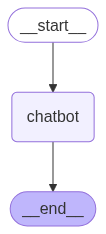

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [23]:
from langchain.tools.tavily_search import TavilySearchResults
from langchain.agents import initialize_agent, AgentType, Tool


# Safe Tavily wrapper
def safe_search(query: str) -> str:
    result = tavily_search.run(query)

    # Ensure result is a string — Tavily returns dict with 'snippets' sometimes
    if isinstance(result, dict):
        result_text = result.get("content", "") or str(result)
    else:
        result_text = str(result)

    tokens = encoding.encode(result_text)
    trimmed = encoding.decode(tokens[:1800])  # leave room for GPT-4 response
    return trimmed


# LangChain tool
tools = [
    Tool(name="TavilySafeSearch", func=safe_search, description="Web search tool")]

from langgraph.prebuilt import create_react_agent
agent = create_react_agent(
    llm,
    tools=tools,
)

ModuleNotFoundError: No module named 'langchain_tavily'

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
# highlight-next-line
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

In [16]:
import torch
print(torch.cuda.is_available())  # should be True

True
